In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_path = '../data/NameTag0.png'

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

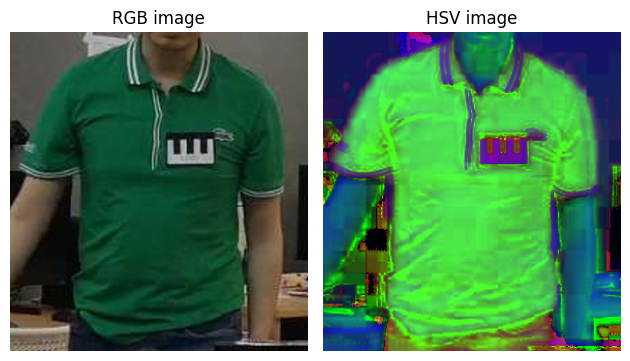

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 cols

ax1.imshow(img_rgb)
ax1.set_title("RGB image")
ax1.axis('off')

ax2.imshow(img_hsv)
ax2.set_title("HSV image")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def get_white_limits():
    # White: Low Saturation (S), High Value (V)
    # 0H scans for red; 0S scans for very pale color; 200V scans for birght color
    lower_limit = np.array([0, 0, 128], dtype=np.uint8) 
    # 180H scans all specturm of color; 30S scans for pale color; 255V scans for even brighter color
    upper_limit = np.array([180, 30, 255], dtype=np.uint8) 
    return lower_limit, upper_limit
    
def get_black_limits():
    # Black: Low Saturation (S), Low Value (V)
    # 0H scans for red; 0S scans for pale color; 0V scans for very dark color
    lower_limit = np.array([0, 0, 0], dtype=np.uint8)
    # 180H scans all specturm of color; 100S scans for slightly pale color; 50V scans for dark color
    upper_limit = np.array([180, 100, 50], dtype=np.uint8) 
    return lower_limit, upper_limit

white_lower, white_upper = get_white_limits()
black_lower, black_upper = get_black_limits()

white_mask = cv2.inRange(img_hsv, white_lower, white_upper)  
black_mask = cv2.inRange(img_hsv, black_lower, black_upper)

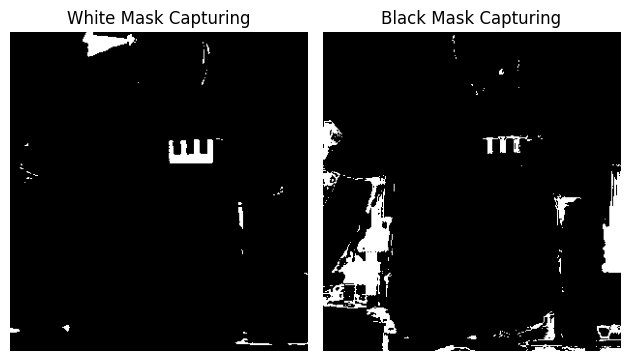

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 cols

ax1.imshow(white_mask, cmap='gray')
ax1.set_title("White Mask Capturing")
ax1.axis('off')

ax2.imshow(black_mask, cmap='gray')
ax2.set_title("Black Mask Capturing")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [7]:
MIN_CONTOUR_AREA = 40 # Contours with area smaller than this value will be discarded
MIN_OVERLAP_AREA = 100 # Overlap with area smaller than this value will be discarded

white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rgb_white_contours = img_rgb.copy()
img_rgb_black_contours = img_rgb.copy()
img_overlap = img_rgb.copy()

# Store data of bounding boxes
white_bboxes = []
black_bboxes = []
overlap_bboxes = []

for cnt in white_contours:
    if cv2.contourArea(cnt) >= MIN_CONTOUR_AREA:
        x, y, w, h = cv2.boundingRect(cnt)
        white_bboxes.append((x, y, w, h))
        cv2.rectangle(img_rgb_white_contours, (x, y), (x+w, y+h), (0, 255, 0), 1)
            
for cnt in black_contours:
    if cv2.contourArea(cnt) >= MIN_CONTOUR_AREA:
        x, y, w, h = cv2.boundingRect(cnt)
        black_bboxes.append((x, y, w, h))
        cv2.rectangle(img_rgb_black_contours, (x, y), (x+w, y+h), (0, 255, 0), 1)

for (x1, y1, w1, h1) in white_bboxes:
    for (x2, y2, w2, h2) in black_bboxes:
        # Check if rectangles overlap
        if (x1 < x2 + w2) and (x1 + w1 > x2) and (y1 < y2 + h2) and (y1 + h1 > y2):     
            # known: White area encloses Black area 
            # cond.1: White's left < Black's right
            # cond.2: White's right > Black's left
            # cond.3: White's top < Black's bottom
            # cond.4: White's bottom > Black's top
            
            x_start = max(x1, x2)
            y_start = max(y1, y2)
            x_end = min(x1+w1, x2+w2)
            y_end = min(y1+h1, y2+h2)

            overlap_w = x_end - x_start
            overlap_h = y_end - y_start

            if overlap_w > 0 and overlap_h > 0:
                overlap_area = overlap_w * overlap_h
                if overlap_area >= MIN_OVERLAP_AREA:
                    area_ratio = overlap_w / overlap_h
                    if area_ratio >= 3 and area_ratio <= 4: # Assumption1: The name tag has this ratio
                        overlap_bboxes.append((x_start, y_start, x_end-x_start, y_end-y_start))

for (x, y, w, h) in overlap_bboxes:
    name_tag_pos_x = x + w + 5
    name_tag_pos_y = y + h//2

    cv2.putText(img_overlap, f"x:{name_tag_pos_x}", (name_tag_pos_x, name_tag_pos_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.putText(img_overlap, f"y:{name_tag_pos_y}", (name_tag_pos_x, name_tag_pos_y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.rectangle(img_overlap, (x, y), (x+w, y+h), (0, 255, 0), 1)

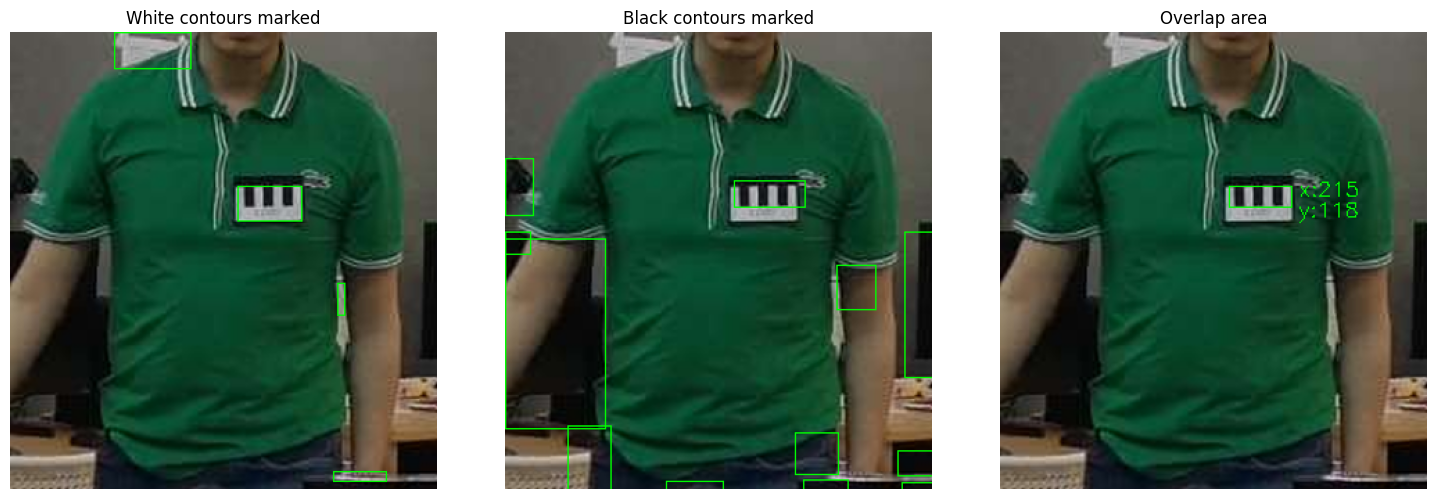

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img_rgb_white_contours)
ax1.set_title("White contours marked")
ax1.axis('off')

ax2.imshow(img_rgb_black_contours)
ax2.set_title("Black contours marked")
ax2.axis('off')

ax3.imshow(img_overlap)
ax3.set_title("Overlap area")
ax3.axis('off')

plt.tight_layout()
plt.show()